# Confronto tra le medie di due gruppi

Diverse procedure di inferenza statistica implicano il confronto tra due gruppi. Potremmo essere interessati a sapere se la media di un gruppo è più grande della media di un altro gruppo, o semplicemente se le due medie sono tra loro diverse. La domanda si riferisce ai parametri delle popolazioni da cui i due gruppi sono stati campionati, *non* alla differenza tra le medie osservate. Per trovare una risposta alla nostra domanda, dunque, abbiamo bisogno di fare ricorso ad un modello statistico, perché le vere differenze sono solitamente offuscate dall'errore di misurazione (o rumore stocastico), il che ci impedisce di trarre conclusioni semplicemente dalle differenze calcolate dai dati osservati.

Lo standard per il confronto statistico tra due (o più) campioni consiste nell'utilizzo di un test statistico. Ciò comporta l'espressione di un'ipotesi nulla, che in genere afferma che non vi è alcuna differenza tra i gruppi, e l'utilizzo di una statistica test scelta per determinare se la distribuzione dei dati osservati è plausibile sotto l'ipotesi nulla. L'ipotesi nulla viene rifiuta quando la statistica del test calcolata sui dati osservati è superiore a un valore soglia prestabilito.

Sfortunatamente, non è facile condurre correttamente un test di ipotesi e i risultati di tali test sono spesso fraintesi. L'impostazione di un test statistico comporta diverse scelte soggettive (ad es. il tipo di test statistico da utilizzare, la specificazione dell'ipotesi nulla da testare, la scelta del livello di significatività) da parte dell'utente che raramente sono giustificate in base al problema, ma piuttosto sono solitamente basate su scelte tradizionali che sono del tutto arbitrare. L'evidenza che fornisce all'utente è indiretta, incompleta e tipicamente soprastima l'evidenza contro l'ipotesi nulla.

Un approccio più informativo ed efficace per confrontare i gruppi è quello basato sulla *stima* piuttosto che sulla *verifica* di ipotesi ed è guidato dall'approccio bayesiano piuttosto che da quello frequentista. Cioè, piuttosto che testare se due gruppi sono diversi, ci poniamo invece il problema di stimare di quanto sono diversi, il che è molto più informativo. Inoltre, in tale stima, includiamo una stima dell'incertezza associata a tale differenza, la quale include l'incertezza dovuta alla nostra mancanza di conoscenza sui parametri del modello (incertezza epistemica) e l'incertezza dovuta alla stocasticità intrinseca del sistema (incertezza aleatoria).

## Un esempio illustrativo

Per illustrare come funziona in pratica l'approccio di stima bayesiana sulla differenza tra le medie di due gruppi, useremo nuovamente i dati `kidiq`. In questo caso i due gruppi di bambini sono identificati dal livello di scolarità della madre: per un primo gruppo di bambini la madre non ha completato le scuole superiori, per il secondo gruppo la madre ha ottenuto il diploma superiore. Ci chiediamo come sia possibile ottenere una stima (nella popolazione) della differenza tra le medie del quoziente di intelligenza del bambino nei due gruppi. In questo capitolo vedremo come sia possibile usare l'analisi della regressione per rispondere a questa domanda.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
from scipy.constants import golden
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [12]:
%matplotlib inline
plt.rc('figure', figsize=(5.0, 5.0/golden))
sns.set_theme()
sns.set_palette("colorblind")
SEED = 12345
rng = np.random.default_rng(SEED)

Leggiamo i dati:

In [4]:
kidiq = pd.read_stata("data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [5]:
kidiq.groupby(["mom_hs"]).size()


mom_hs
0.0     93
1.0    341
dtype: int64

Ci sono 93 bambini la cui madre non ha completato le superiori e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [10]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)


kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

I bambini la cui madre ha completato le superiori tendono ad avere un QI maggiore di 11.8 punti rispetto ai bambini la cui madre non ha concluso le superiori.

In [70]:
89.319648 - 77.548387

11.771260999999996

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

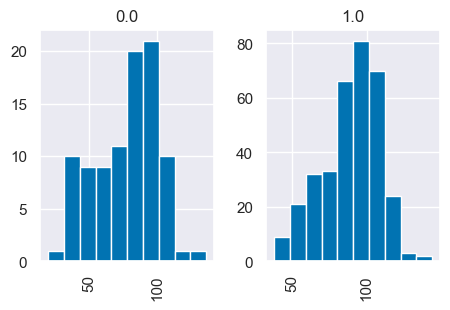

In [13]:
kidiq.hist("kid_score", by="mom_hs")

Iniziamo la nostra inferenza statistica usando `bambi`. Per semplicità, ricodifichiamo la variabile che distingue i due gruppi di madri nel modo seguente:

In [14]:
kidiq["mom_hs_f"] = np.where(kidiq["mom_hs"] == 1.0, "yes", "no")


In [15]:
kidiq.describe

<bound method NDFrame.describe of      kid_score  mom_hs      mom_iq  mom_work  mom_age mom_hs_f
0           65     1.0  121.117529         4       27      yes
1           98     1.0   89.361882         4       25      yes
2           85     1.0  115.443165         4       27      yes
3           83     1.0   99.449639         3       25      yes
4          115     1.0   92.745710         4       27      yes
..         ...     ...         ...       ...      ...      ...
429         94     0.0   84.877412         4       21       no
430         76     1.0   92.990392         4       23      yes
431         50     0.0   94.859708         2       24       no
432         88     1.0   96.856624         2       21      yes
433         70     1.0   91.253336         2       25      yes

[434 rows x 6 columns]>

Scriviamo il modello statistico nel modo seguente:

In [16]:
model = bmb.Model("kid_score ~ 0 + mom_hs_f", kidiq)


La variabile `mom_hs_f` è una variabile categoriale e verrà trasformata automaticamente da `bambi` in maniera tale che le stime dei due coefficienti del modello corrisponderanno alle medie dei due gruppi.

In [17]:
idata = model.fit(draws=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, mom_hs_f]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.


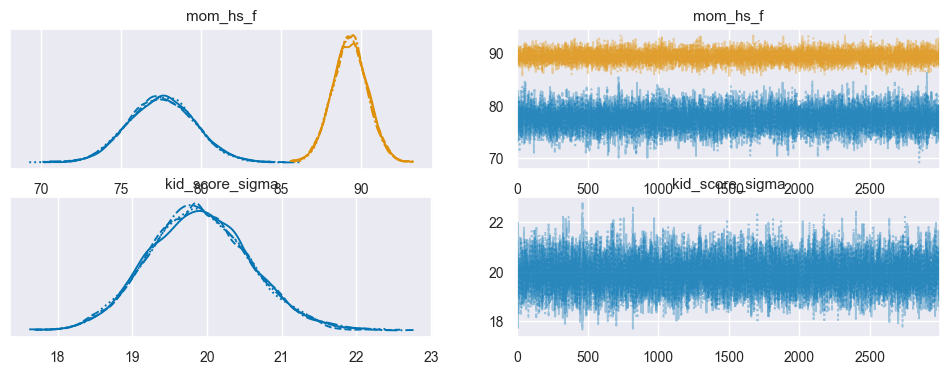

In [18]:
_ = az.plot_trace(idata)


In [19]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mom_hs_f[no],77.533,2.046,73.667,81.306,0.016,0.011,17287.0,10085.0,1.0
mom_hs_f[yes],89.314,1.096,87.274,91.415,0.008,0.006,17091.0,8835.0,1.0
kid_score_sigma,19.897,0.677,18.672,21.223,0.005,0.004,17394.0,9132.0,1.0


Il parametro associato alla modalità `no` corrisponde alla media del QI del gruppo dei bambini la cui madre non ha completato le scuole superiori. Il parametro associato alla modalità `yes` corrisponde alla media del QI del gruppo dei bambini la cui madre ha completato le scuole superiori. 

Ai due parametri è associato un intervallo di credibilità. La quantità di sovrapposizione tra i due intervalli ci fornisce una certezza più o meno grande della differenza tra le medie delle due popolazioni. Nel caso presente, per intervalli del 94%, non vi è alcuna sovrapposizione. Per cui, con un livello di certezza del 94% possiamo concludere che il QI dei bambini la cui madre ha completato le superiori tende ad essere maggiore del QI dei bambini la cui madre non ha completato le superiori. 

Ripetiamo ora l'analisi usando una parametrizzazione divera.  In questo caso useremo PyMC.

Iniziamo ad estrarre le variabili dal DataFrame.

In [20]:
kid_score = kidiq["kid_score"]
mom_hs = kidiq["mom_hs"]


Specifichiamo ora il modello PyMC.

In [21]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 2

with Model() as model:

    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=20)
    # Expected value of outcome
    mu = alpha + beta * mom_hs
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kid_score)


Eseguiamo il campionamento.

In [22]:
with model:
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Esaminiamo i risultati.

In [24]:
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.087,2.027,74.215,81.802,0.050,0.035,1683.0,1709.0,1.0
beta,11.078,2.297,6.745,15.395,0.056,0.039,1714.0,1727.0,1.0
sigma,19.877,0.686,18.592,21.158,0.014,0.010,2321.0,2382.0,1.0


In questo caso, abbiamo specificato un modello di regressione con la forma seguente:

$$
\mathbb{E}(Y) = \alpha + \beta X.
$$

La variabile $X$ assume il valore 0 per il primo gruppo. Per quel gruppo, dunque, il modello si riduce a

$$
\mathbb{E}(Y) = \alpha.
$$

Il parametro $\alpha$ corrisponde dunque alla media di `kid_score` per il gruppo codificato con `mom_hs` = 0.

Per il secondo gruppo, con `mom_hs` = 1, il modello diventa

$$
\mathbb{E}(Y) = \alpha + \beta.
$$

Il $\mathbb{E}(Y)$ è la media del secondo gruppo. Dato che $\alpha$ corrisponde alla media di `kid_score` per il primo gruppo, questo significa che $\beta$ corrisponde alla differenza tra le medie dei due gruppi. 

In [24]:
77.539 + 11.767

89.306

L'incertezza a proposito della differenza tra le medie dei due gruppi (ovvero, l'incertezza associata al parametro $\beta$) rappresenta l'oggetto del nostro interesse. Pertanto, l'intervallo di credibilità associato al parametro $\beta$ è la risposta alla domanda che ci eravamo posti: ci sono evidenze convincenti che le medie dei due gruppi sono diverse?  Se l'intervallo di credibilità non include lo 0 (il che significa che non vi è differenza tra i due gruppi) allora, al livello di credibilità prescelto, possiamo concludere che le due medie sono diverse.

## Dimensione dell'effetto 

La dimensione dell'effetto (*effect size*) è una misura della forza dell'associazione osservata, ovvero della grandezza della differenza tra i gruppi attesa che include l'incertezza sui dati. L'indice maggiormente usato per quantificare la dimensione dell'effetto è l'indice $d$ di Cohen. Nel caso di due medie abbiamo:

$$
d={\frac {{\bar {x}}_{1}-{\bar {x}}_{2}}{s}},
$$

laddove

$$
s={\sqrt {\frac {(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}}
$$

e la varianza di ciascun gruppo è calcolata come

$$
s_{1}^{2}={\frac {1}{n_{1}-1}}\sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2}.
$$

Solitamente, l'indice $d$ di Cohen si interpreta usando la metrica seguente:

| Dimensione dell'effetto |   $d$   |
| ----------------------- | ------- |
| Very small              | 0.01	|
| Small                   | 0.20	|
| Medim                   | 0.50	|
| Large                   | 0.80	|
| Very large              | 1.20	|
| Huge                    | 2.0     |

Per una trattazione bayesiana (in un caso più complesso del presente) della stima della dimensione dell'effetto, si veda {cite}`doing_bayesian_data_an`.

In [25]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 2

with Model() as model_ef:

    # Define priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=30)
    sigma = pm.HalfCauchy("sigma", beta=20)
    # Expected value of outcome
    mu = alpha + beta * mom_hs
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kid_score)
    effect_size = pm.Deterministic("effect_size", beta / sigma)
    trace_ef = pm.sample(2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


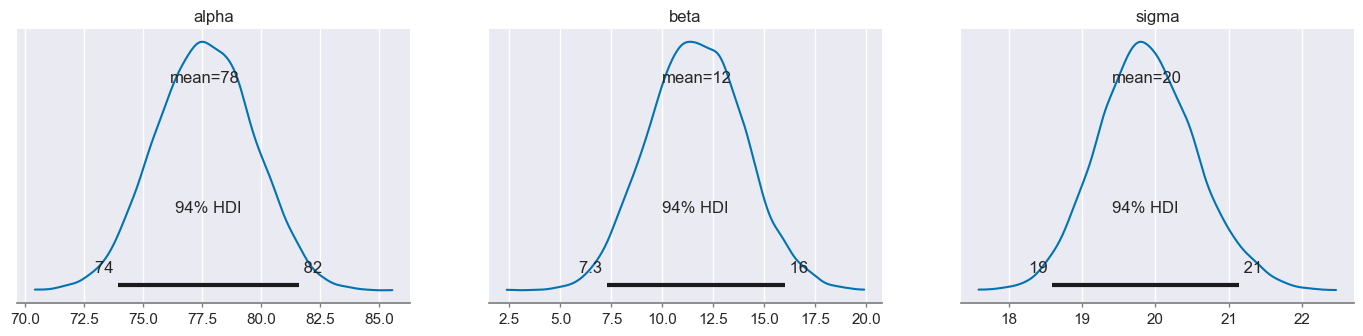

In [26]:
_ = az.plot_posterior(trace_ef, var_names=["alpha", "beta", "sigma"])


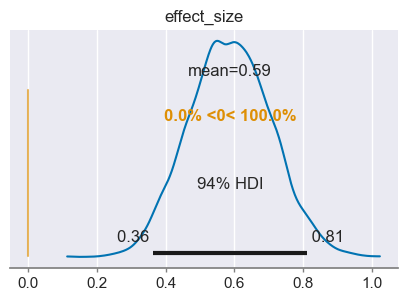

In [27]:
_ = az.plot_posterior(trace_ef, ref_val=0, var_names=["effect_size"])


In [28]:
az.summary(trace_ef)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,77.632,2.063,73.929,81.594,0.036,0.026,3236.0,3442.0,1.0
beta,11.669,2.340,7.273,15.990,0.041,0.029,3296.0,3658.0,1.0
sigma,19.888,0.672,18.593,21.137,0.010,0.007,4653.0,4228.0,1.0
effect_size,0.587,0.119,0.365,0.810,0.002,0.001,3313.0,3564.0,1.0


Possiamo dunque concludere che, per ciò che concerne l'effetto della scolarità della madre sul quoziente di intelligenza del bambino, la dimensione dell'effetto è "media".

## Watermark

In [86]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Jan 04 2023

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.7.0

arviz     : 0.14.0
scipy     : 1.9.3
bambi     : 0.9.2
pymc      : 5.0.0
matplotlib: 3.6.2
numpy     : 1.24.0
sys       : 3.8.15 (default, Nov 24 2022, 09:04:07) 
[Clang 14.0.6 ]
pandas    : 1.5.2

Watermark: 2.3.1

